<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report 

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

In [6]:
def moveup(img):
    while True:
        if np.all(img[0] >= 240):
            img = img[1:]
        else:
            break
    return img

def movedown(img):
    while True:
        if np.all(img[-1] >= 240):
            img = img[:-1]
        else:
            break
    return img

def moveleft(img):
    while True:
        if np.all(img[:, 0] >= 240):
            img = img[:, 1:]
        else:
            break
    return img

def moveright(img):
    while True:
        if np.all(img[:, -1] >= 240):
            img = img[:, :-1]
        else:
            break
    return img

def rescale(img):
    img = moveup(img)
    img = movedown(img)
    img = moveleft(img)
    img = moveright(img)
    return img

# STEP 2 : Preparing & inspection

Prepare for inspections

In [7]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [8]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\9\9-6.png,9
1,./Thainumber\4\4-36.png,4
2,./Thainumber\6\6-8.png,6
3,./Thainumber\3\IMG_0885.png,3
4,./Thainumber\3\IMG_0886.png,3
...,...,...
695,./Thainumber\9\IMG_0951.png,9
696,./Thainumber\2\2-b.png,2
697,./Thainumber\9\IMG_0945.png,9
698,./Thainumber\3\3-10.png,3


In [9]:
data.shape

(700, 2)

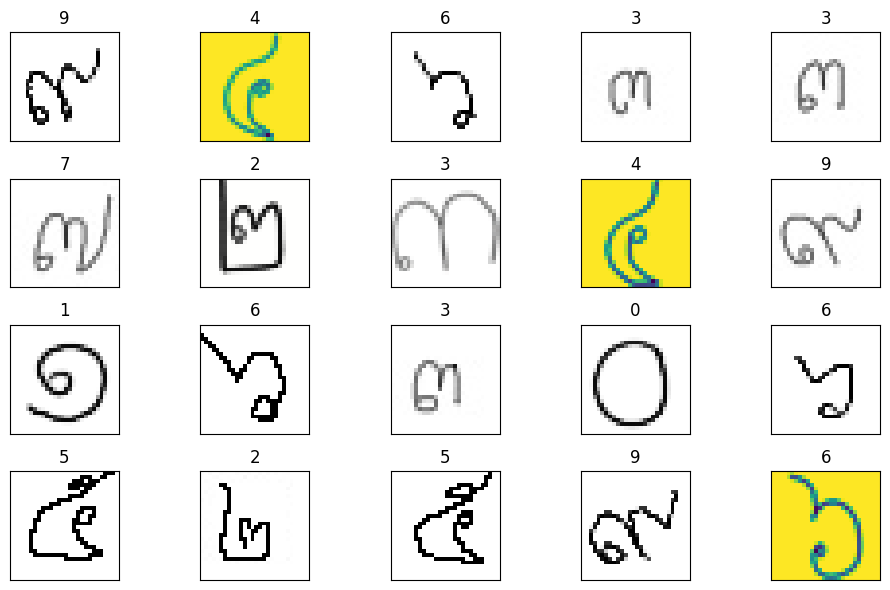

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

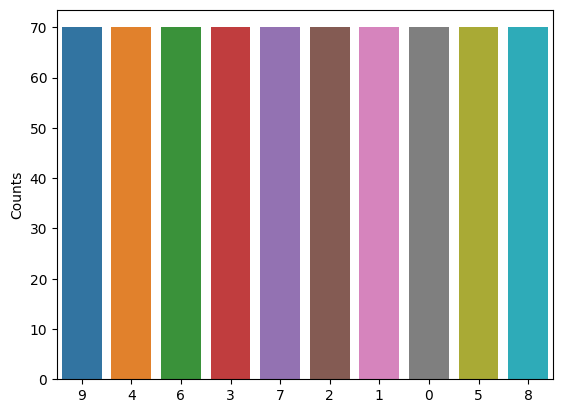

In [11]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [12]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = rescale(img)
    img = cv2.resize(img, (28, 28))
    img = img.flatten()
 
    read_x.append(img)

x = np.asarray(read_x)

In [13]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [14]:
df = pd.concat([x,y] , axis=1)
#df.to_csv('image_df.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,9
1,255,255,255,255,255,255,255,255,255,255,...,252,245,232,213,200,195,207,238,253,4
2,96,153,244,255,255,255,255,255,255,255,...,101,16,16,101,238,255,255,255,255,6
3,255,255,255,255,255,254,253,250,246,242,...,255,255,255,255,255,255,254,254,254,3
4,255,255,255,255,255,255,253,251,237,222,...,255,255,254,254,254,255,255,255,255,3


In [15]:
# Binarize the output

#y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
#print(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.30, random_state = 42, stratify = y )

# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [17]:
from pycaret.classification import *

s = setup( df, target = 'Label', session_id = 123, train_size = 0.7  )

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Multiclass
3,Target mapping,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9"
4,Original data shape,"(700, 785)"
5,Transformed data shape,"(700, 785)"
6,Transformed train set shape,"(489, 785)"
7,Transformed test set shape,"(211, 785)"
8,Numeric features,784
9,Preprocess,True


In [18]:
best = s.compare_models( sort = 'Accuracy', fold = 5, n_select = 5 )
pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9612,0.9986,0.9612,0.9651,0.9610,0.9569,0.9574,2.434
lr,Logistic Regression,0.9530,0.9961,0.9530,0.9598,0.9531,0.9477,0.9485,3.264
rf,Random Forest Classifier,0.9489,0.9982,0.9489,0.9513,0.9487,0.9432,0.9435,2.488
lightgbm,Light Gradient Boosting Machine,0.9469,0.9969,0.9469,0.9499,0.9464,0.9410,0.9414,3.524
knn,K Neighbors Classifier,0.9264,0.9911,0.9264,0.9370,0.9268,0.9182,0.9193,2.764
svm,SVM - Linear Kernel,0.9162,0.0000,0.9162,0.9253,0.9155,0.9069,0.9081,2.296
gbc,Gradient Boosting Classifier,0.9039,0.9928,0.9039,0.9154,0.9046,0.8932,0.8945,13.708
lda,Linear Discriminant Analysis,0.8548,0.9762,0.8548,0.8696,0.8550,0.8387,0.8403,2.340
nb,Naive Bayes,0.7711,0.8970,0.7711,0.8134,0.7710,0.7456,0.7508,2.252
dt,Decision Tree Classifier,0.7690,0.8715,0.7690,0.7821,0.7667,0.7432,0.7451,2.282


In [19]:
display(best)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        

In [20]:
tuned_model = tune_model( best[0], optimize = 'Accuracy', n_iter = 30, fold = 5 )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9796,0.9959,0.9796,0.9796,0.9796,0.9773,0.9773
1,0.9184,0.9907,0.9184,0.9212,0.9170,0.9093,0.9099
2,0.9490,0.9927,0.9490,0.9552,0.9492,0.9433,0.9439
3,0.9592,0.9970,0.9592,0.9610,0.9591,0.9546,0.9549
4,0.9691,0.9985,0.9691,0.9697,0.9689,0.9656,0.9657
Mean,0.9550,0.9950,0.9550,0.9573,0.9548,0.9500,0.9504
Std,0.0210,0.0028,0.0210,0.0199,0.0214,0.0233,0.0231


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


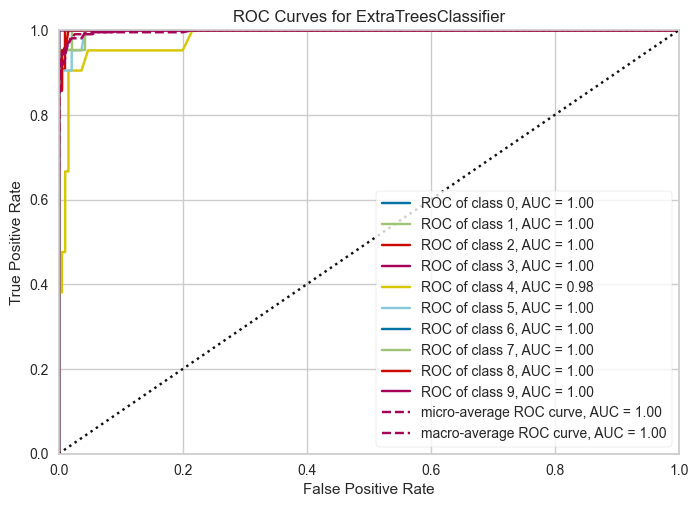

In [21]:
plot_model(tuned_model, plot = 'auc')

<h4>Pipeline</h4>

In [25]:
steps = [
    ('scalar', MinMaxScaler()),
    ('ExtraTreesClassifier',ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False))
]

pipeline = Pipeline(steps)

In [26]:
pr = pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))

Training score: 1.0


# STEP 4 : Test

In [27]:
y_pred = pr.predict(X_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        21
           4       0.91      0.95      0.93        21
           5       0.95      0.90      0.93        21
           6       1.00      1.00      1.00        21
           7       1.00      0.95      0.98        21
           8       0.95      1.00      0.98        21
           9       1.00      1.00      1.00        21

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



<h4>Evaluations</h4>